<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Library_Simplify_ProductionML_1027.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

## Visualization (Plotting)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import count

FIG_NO = count(1)

def draw_triptych(title_prefix, Kv, Lv, y_true, y_pred,
                  vmin=0.0, vmax=1.0, fig_no=None, caption=None):
    if fig_no is None:
        fig_no = next(FIG_NO)

    mse = (y_true - y_pred) ** 2

    fig = plt.figure(figsize=(18, 5))
    gs = GridSpec(
        nrows=1, ncols=9, figure=fig,
        width_ratios=[1, 0.04, 0.2, 1, 0.04, 0.2, 1, 0.04, 0.2]
    )

    # (1) True
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    sc1 = ax1.scatter(Kv, Lv, y_true, c=y_true, alpha=0.8, s=14)
    ax1.set_title(f"(a) {title_prefix} True Y")
    ax1.set_xlabel("K"); ax1.set_ylabel("L"); ax1.set_zlabel("Y")
    ax1.set_xlim(0, 1); ax1.set_ylim(0, 1)
    cax1 = fig.add_subplot(gs[0, 1])
    cb1 = fig.colorbar(sc1, cax=cax1)
    cb1.set_label("Y", fontsize=13)
    cb1.ax.tick_params(labelsize=11)

    # (2) Predicted
    ax2 = fig.add_subplot(gs[0, 3], projection='3d')
    sc2 = ax2.scatter(Kv, Lv, y_pred, c=y_pred, alpha=0.8, s=14)
    ax2.set_title(f"(b) {title_prefix} Predicted Ŷ")
    ax2.set_xlabel("K"); ax2.set_ylabel("L"); ax2.set_zlabel("Ŷ")
    ax2.set_xlim(0, 1); ax2.set_ylim(0, 1)
    cax2 = fig.add_subplot(gs[0, 4])
    cb2 = fig.colorbar(sc2, cax=cax2)
    cb2.set_label("Ŷ", fontsize=13)
    cb2.ax.tick_params(labelsize=11)

    # (3) MSE
    ax3 = fig.add_subplot(gs[0, 6], projection='3d')
    sc3 = ax3.scatter(Kv, Lv, y_true, c=mse, cmap="Reds",
                      alpha=0.8, s=14, vmin=vmin, vmax=vmax)
    ax3.set_title(f"(c) {title_prefix} MSE ( (Y−Ŷ)^2 )")
    ax3.set_xlabel("K"); ax3.set_ylabel("L"); ax3.set_zlabel("Y (at truth)")
    ax3.set_xlim(0, 1); ax3.set_ylim(0, 1)
    cax3 = fig.add_subplot(gs[0, 7])
    cb3 = fig.colorbar(sc3, cax=cax3)
    cb3.set_label("MSE", fontsize=13)
    cb3.ax.tick_params(labelsize=11)

    cap = f"Figure {fig_no}. {caption}" if caption else f"Figure {fig_no}. {title_prefix}"
    fig.suptitle(cap, fontsize=20, y=0.97)

    fig.subplots_adjust(
        left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.6
    )

    plt.show()


## Data Generation

- **Two dataset types**
  1. **K-intensive**
     - $K \sim U(0,1)$
     - $L = 0$
  2. **L-intensive**
     - $K = 0$
     - $L \sim U(0,1)$

- **Three target functions (each with noise)**
  1. $y = K^3 + \epsilon$
  2. $y = -K^3 + \epsilon$
  3. $y = L^3 + \epsilon$

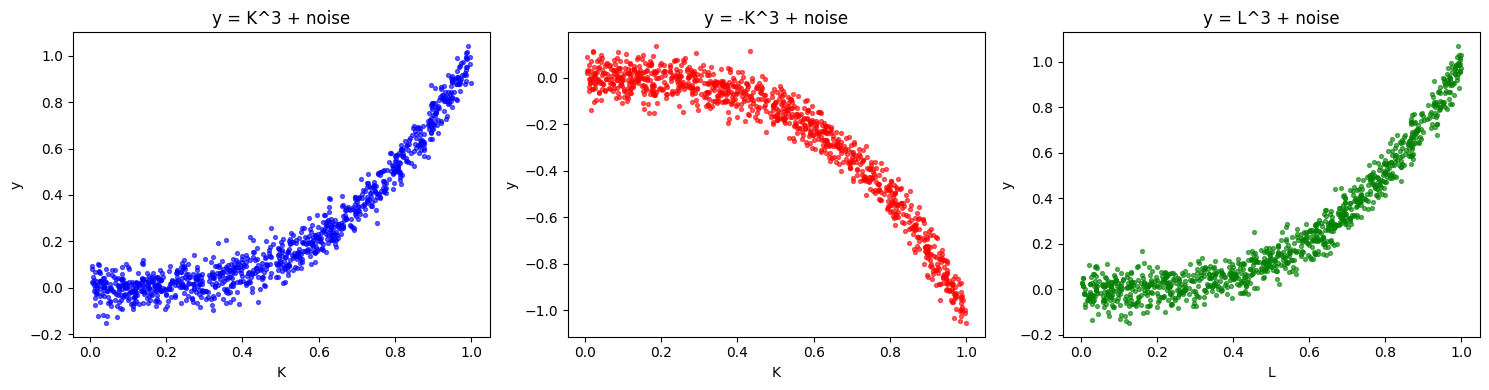

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# === 1. Data ===
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))

# ===== Visualization =====
fig, axs = plt.subplots(1, 3, figsize=(15,4))

# 1. y = K^3
axs[0].scatter(K, y1, color="blue", s=8, alpha=0.6, label="K intensive")
axs[0].set_title("y = K^3 + noise")
axs[0].set_xlabel("K")
axs[0].set_ylabel("y")

# 2. y = -K^3
axs[1].scatter(K, y2, color="red", s=8, alpha=0.6, label="K intensive")
axs[1].set_title("y = -K^3 + noise")
axs[1].set_xlabel("K")
axs[1].set_ylabel("y")

# 3. y = L^3
axs[2].scatter(L, y3, color="green", s=8, alpha=0.6, label="L intensive")
axs[2].set_title("y = L^3 + noise")
axs[2].set_xlabel("L")
axs[2].set_ylabel("y")

plt.tight_layout()
plt.show()


## Build & Train Model

### Build Original Model

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda

# Original Model - 5 layer trained on y1
def build_model():
    model = Sequential([
        tf.keras.Input(shape=(2,)),
        Lambda(tf.nn.relu, name="input_relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_model()
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_relu (Lambda)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177 (708.00 B)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

### Build TL Models

In [36]:
# TL Model 1 - Train on y1 data -> Transfer Learning to y2 data (last 2 layers)
model_tf_y2 = Sequential()
for i in range(3):
    layer = model.layers[i]
    layer.trainable = False
    model_tf_y2.add(layer)

model_tf_y2.add(Dense(8, activation="relu"))
model_tf_y2.add(Dense(1))
model_tf_y2.compile(optimizer="adam", loss="mse")

model_tf_y2.fit(X_K, y2, verbose=0, epochs=100, batch_size=32)

# TL Model 2 - Train on y1 data -> Transfer Learning to y3 data (last 2 layers)
model_tf_y3 = Sequential()
for i in range(3):
    layer = model.layers[i]
    layer.trainable = False
    model_tf_y3.add(layer)

model_tf_y3.add(Dense(8, activation="relu"))
model_tf_y3.add(Dense(1))
model_tf_y3.compile(optimizer="adam", loss="mse")

model_tf_y3.fit(X_L, y3, verbose=0, epochs=100, batch_size=32)

### Train on y1(K-intensive) 10 times

See what happens if the NN model encounters data on production functions with untrained parameters.

(Only trained on K -> predict data on L)

In [6]:
# ---------- Train 10 independent models on y1, evaluate on L ----------
n_trials = 10
L_preds = []

for t in range(n_trials):
    print(f"[Trial {t+1}/{n_trials}] training on y1 ...")
    m = build_model()
    m.fit(X_K, y1, epochs=50, batch_size=32, verbose=0)  # train ONLY on y1
    L_pred_t = m.predict(X_L, verbose=0).ravel()
    L_preds.append(L_pred_t)

L_preds = np.vstack(L_preds)                             # shape (10, N)
L_true_1d = y3.ravel()
K0_1d = K0.ravel()
L_1d  = L.ravel()

mse_all = (L_preds - L_true_1d)**2                      # (10, N)
vmin, vmax = 0.0, 1.0

[Trial 1/10] training on y1 ...
[Trial 2/10] training on y1 ...
[Trial 3/10] training on y1 ...
[Trial 4/10] training on y1 ...
[Trial 5/10] training on y1 ...
[Trial 6/10] training on y1 ...
[Trial 7/10] training on y1 ...
[Trial 8/10] training on y1 ...
[Trial 9/10] training on y1 ...
[Trial 10/10] training on y1 ...


### OLS vs. ReLU Functions

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

def run_comparison(X, y, x_scalar, xlabel, title_prefix):
    # train/test split
    X_tr, X_te, y_tr, y_te, x_tr, x_te = train_test_split(
        X, y, x_scalar, test_size=0.3, random_state=42
    )

    g = np.linspace(0, 1, 400).reshape(-1, 1)
    if xlabel == "K":
        X_grid = np.hstack([g, np.zeros_like(g)])
        y_grid_true = g**3
    else:  # L
        X_grid = np.hstack([np.zeros_like(g), g])
        y_grid_true = g**3

    # ---- OLS ----
    ols = LinearRegression()
    ols.fit(X_tr, y_tr)
    y_te_pred_ols = ols.predict(X_te)
    y_grid_pred_ols = ols.predict(X_grid)
    mse_ols = mean_squared_error(y_te, y_te_pred_ols)

    # ---- ReLU NN ----
    nn = build_model()
    nn.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=0)

    y_te_pred_nn = nn.predict(X_te, verbose=0)
    y_grid_pred_nn = nn.predict(X_grid, verbose=0)
    mse_nn = mean_squared_error(y_te, y_te_pred_nn)

    print(f"[{title_prefix}] Test MSE - OLS: {mse_ols:.6f} | ReLU NN: {mse_nn:.6f}")

    fig = plt.figure(figsize=(12, 8))

    # (True vs OLS vs NN)
    ax1 = plt.subplot(2, 1, 1)
    ax1.scatter(x_tr, y_tr, s=10, alpha=0.35, label="train")
    ax1.plot(g, y_grid_true, lw=2, label="true (noiseless)")
    ax1.plot(g, y_grid_pred_ols, lw=2, linestyle="--", label="OLS")
    ax1.plot(g, y_grid_pred_nn, lw=2, linestyle="-.", label="ReLU NN")
    ax1.set_xlim(0, 1)
    ax1.set_xlabel(xlabel); ax1.set_ylabel("y")
    ax1.set_title(f"[{title_prefix}] Fit comparison (train scatter + curves)")
    ax1.legend(loc="best")

    # OLS vs NN
    res_ols = (y_te - y_te_pred_ols).ravel()
    res_nn  = (y_te - y_te_pred_nn).ravel()
    res_max = np.percentile(np.abs(np.concatenate([res_ols, res_nn])), 99)
    ylim = (-res_max, res_max)

    ax2 = plt.subplot(2, 2, 3)
    ax2.scatter(x_te, res_ols, s=12, alpha=0.7)
    ax2.axhline(0, color="black", lw=1)
    ax2.set_xlim(0, 1); ax2.set_ylim(*ylim)
    ax2.set_xlabel(xlabel); ax2.set_ylabel("Residual (Y−Ŷ)")
    ax2.set_title(f"Residuals (OLS)  MSE={mse_ols:.4f}")

    ax3 = plt.subplot(2, 2, 4)
    ax3.scatter(x_te, res_nn, s=12, alpha=0.7)
    ax3.axhline(0, color="black", lw=1)
    ax3.set_xlim(0, 1); ax3.set_ylim(*ylim)
    ax3.set_xlabel(xlabel); ax3.set_ylabel("Residual (Y−Ŷ)")
    ax3.set_title(f"Residuals (ReLU NN)  MSE={mse_nn:.4f}")

    plt.tight_layout()
    plt.show()

# Run

### OLS vs. ReLU

[K^3 target] Test MSE - OLS: 0.015044 | ReLU NN: 0.002469


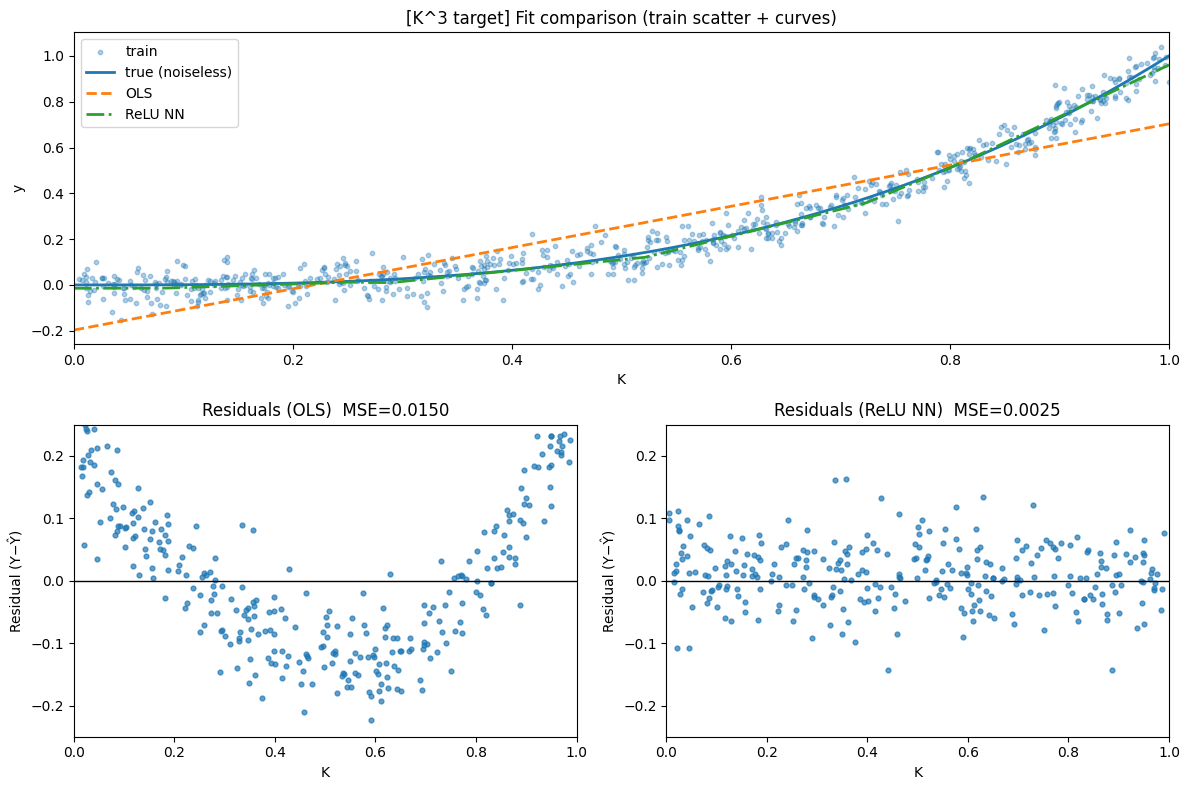

In [8]:
run_comparison(X_K, y1, K, xlabel="K", title_prefix="K^3 target")

### Draw Mean of y1(K-intensive) 10 times -> evaluate on L data

Random Predictions on Parameters that the model wasn't trained on (L)

[Trial 1/10] plotting ...


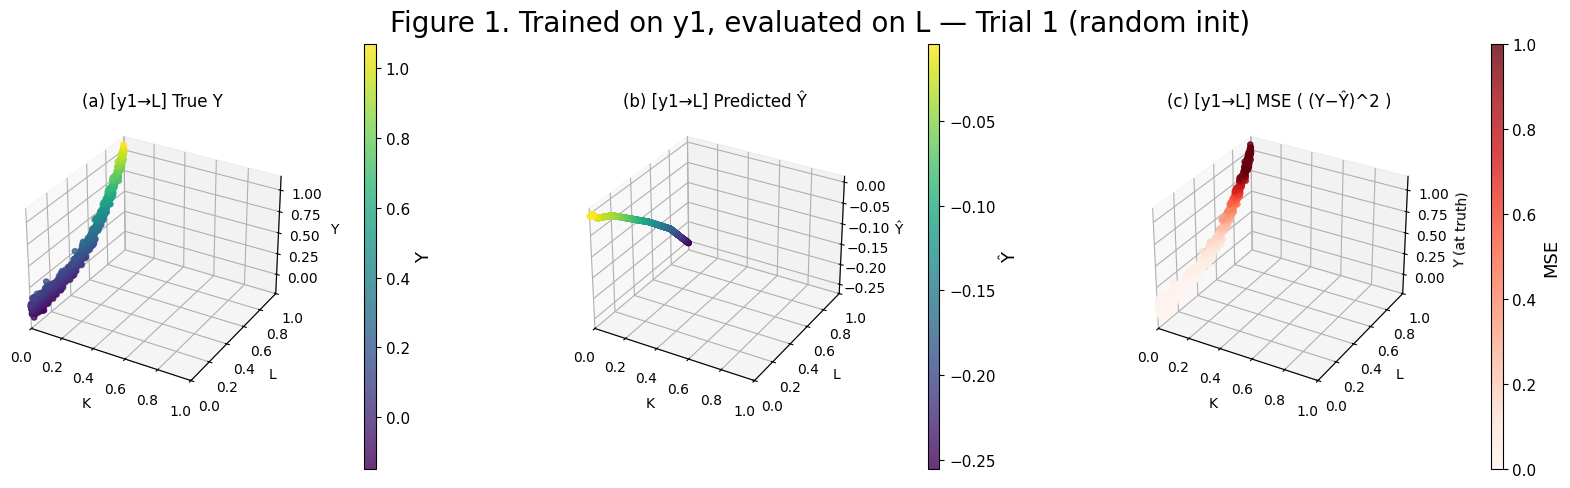

[Trial 2/10] plotting ...


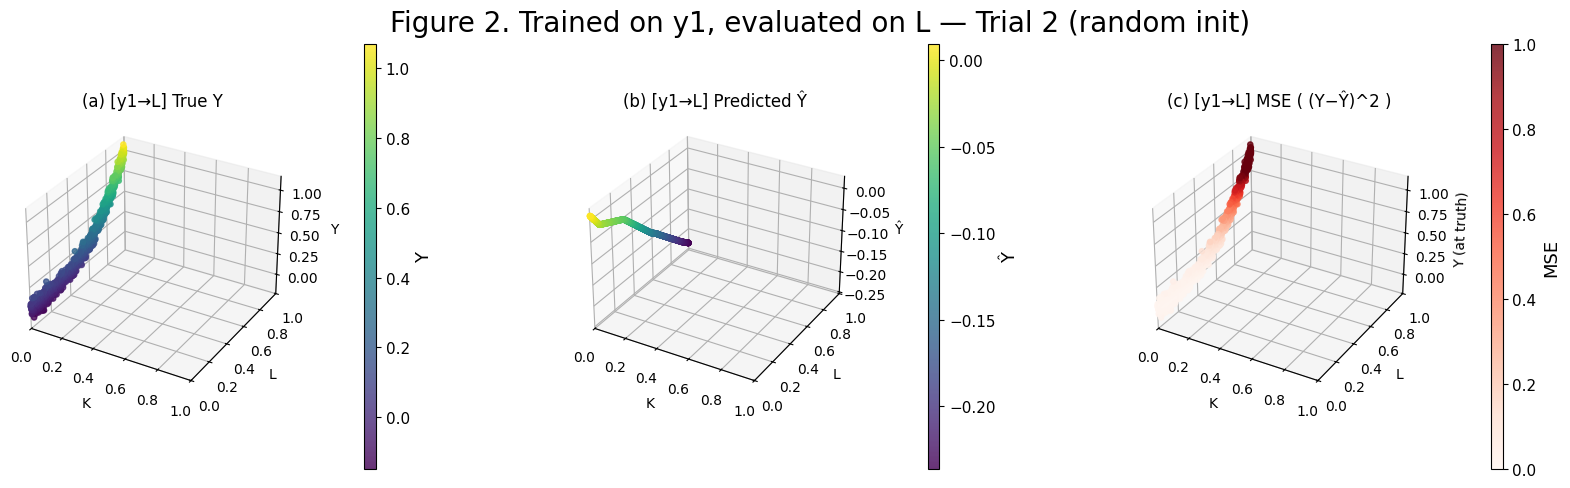

[Trial 3/10] plotting ...


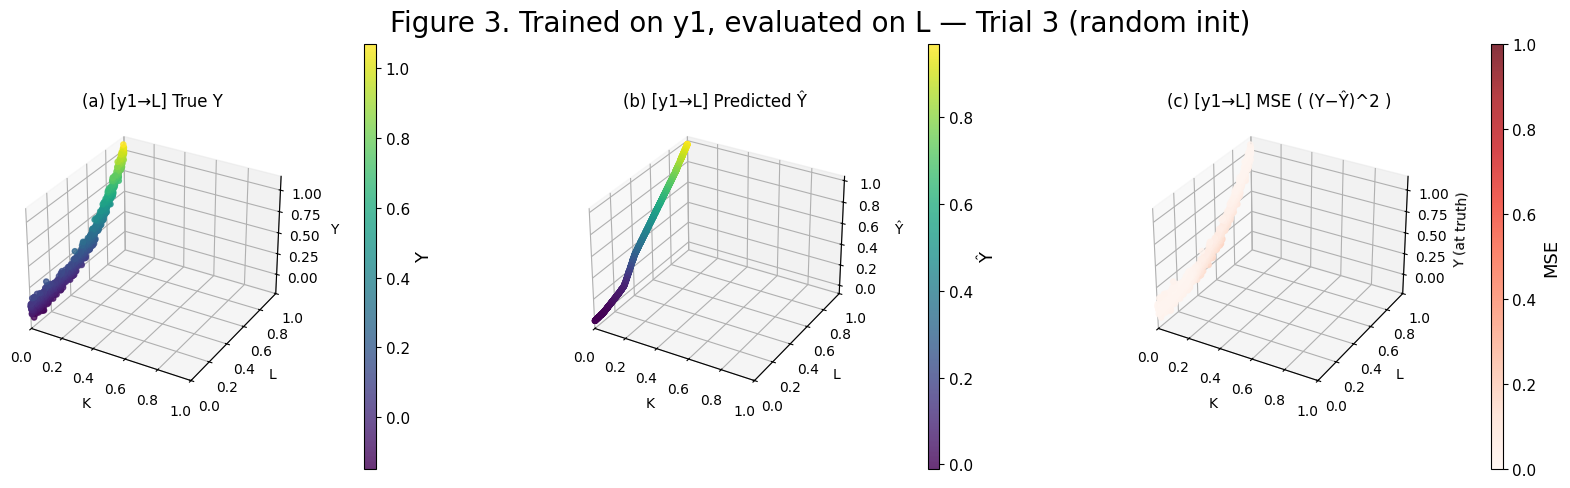

[Trial 4/10] plotting ...


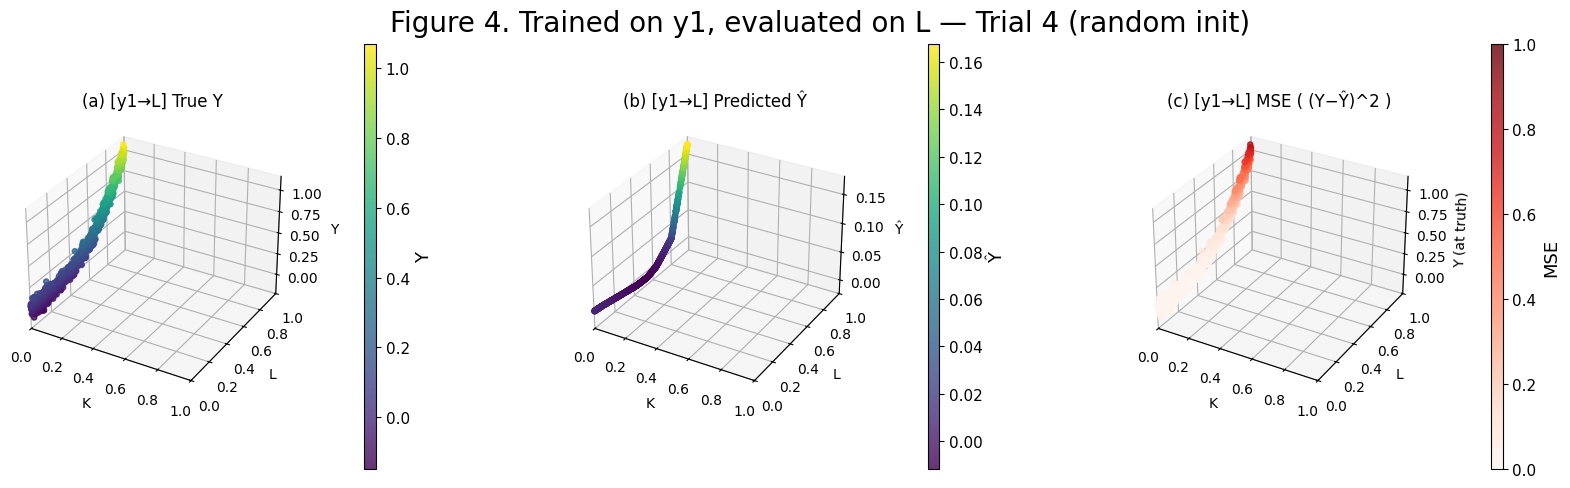

[Trial 5/10] plotting ...


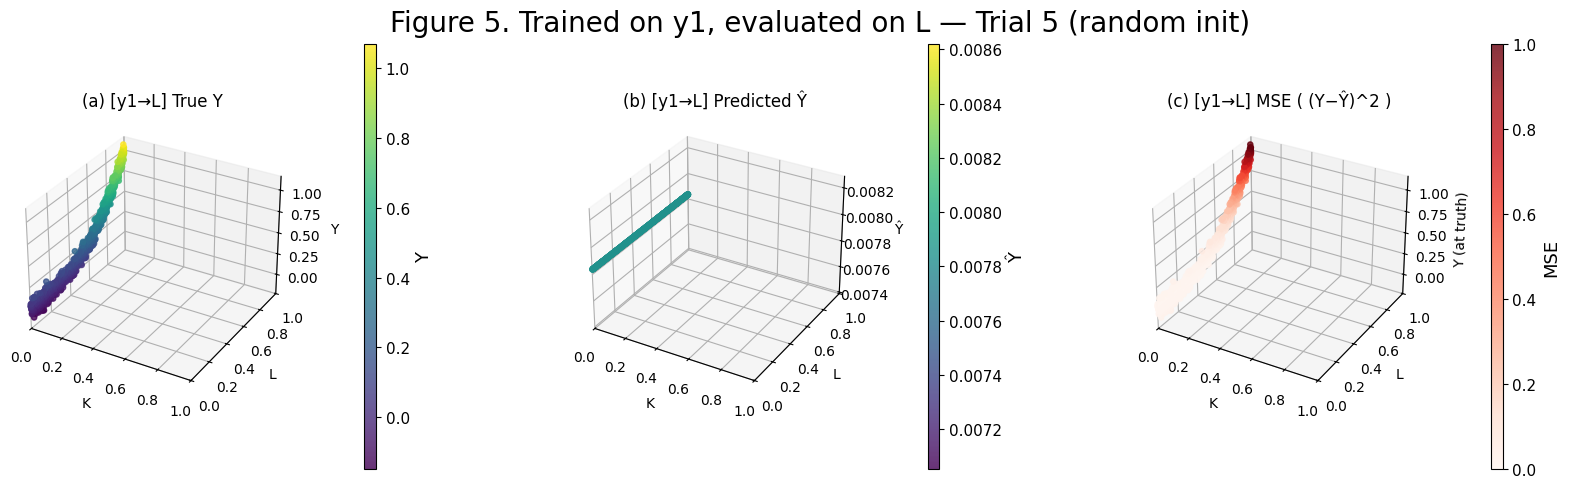

[Trial 6/10] plotting ...


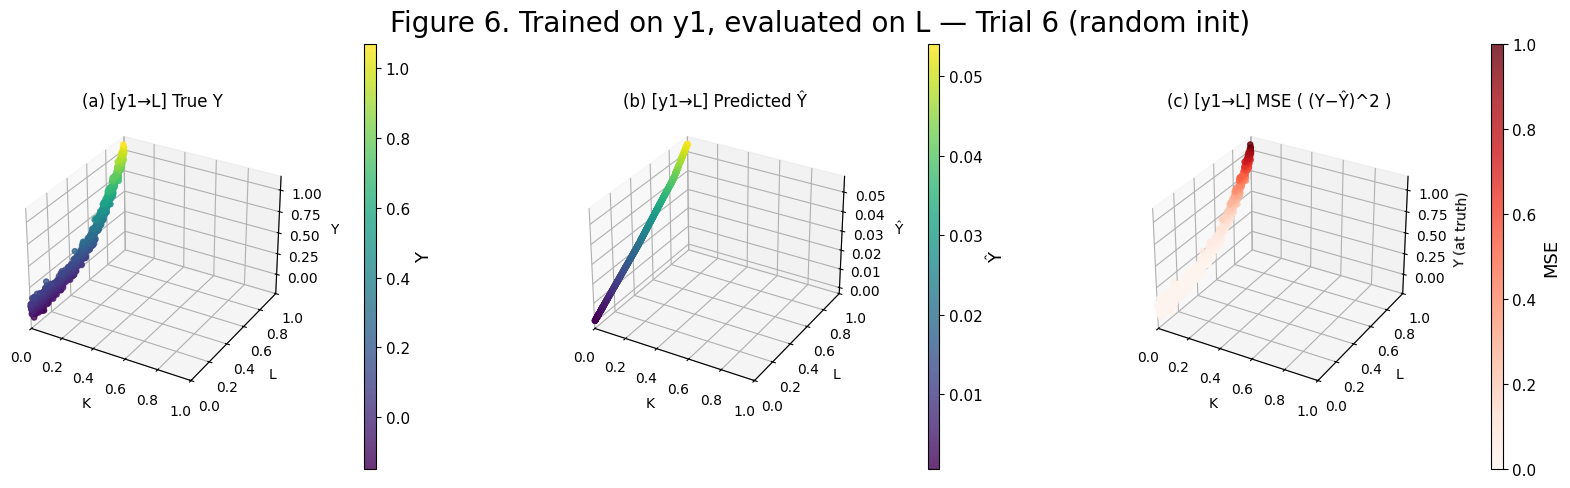

[Trial 7/10] plotting ...


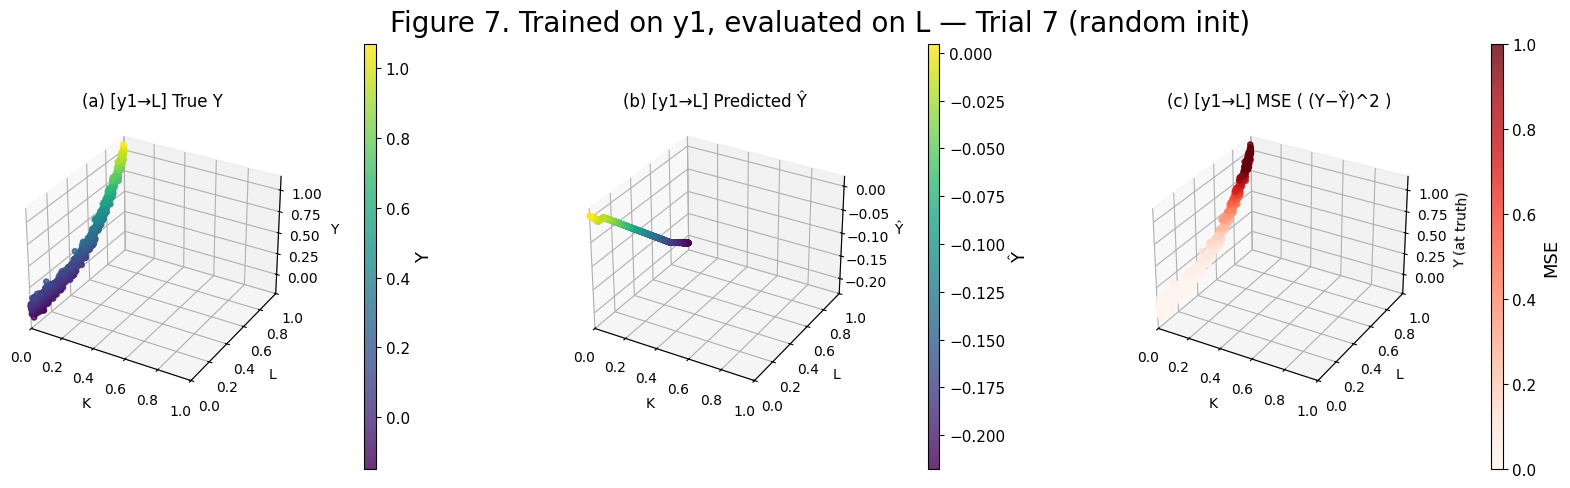

[Trial 8/10] plotting ...


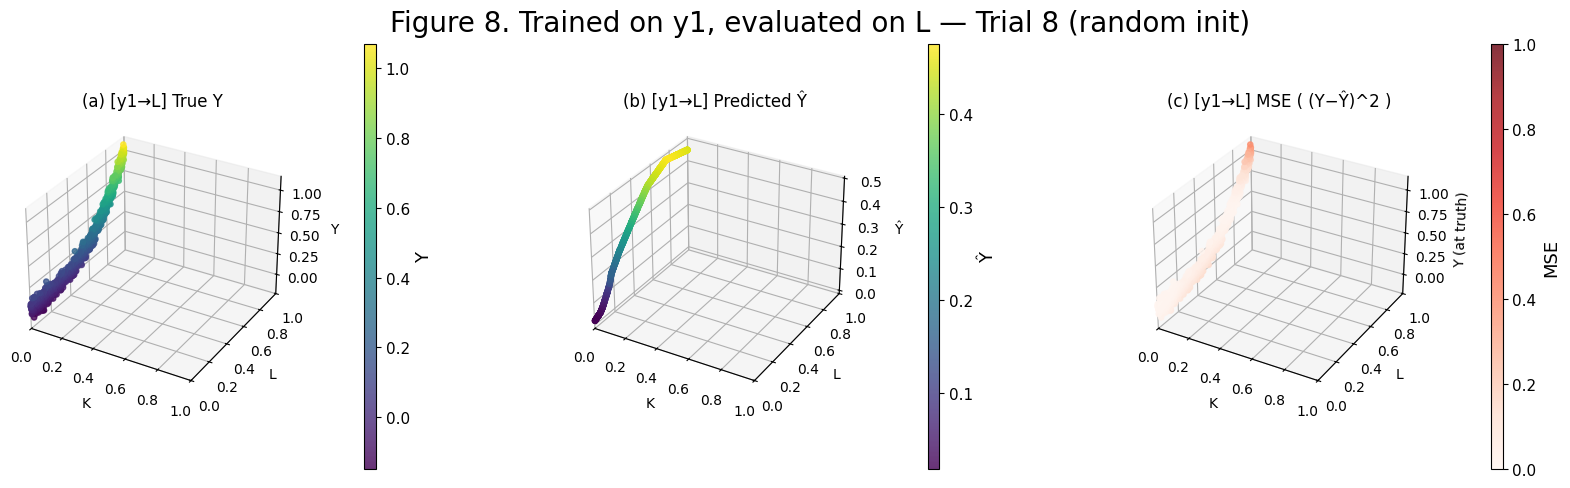

[Trial 9/10] plotting ...


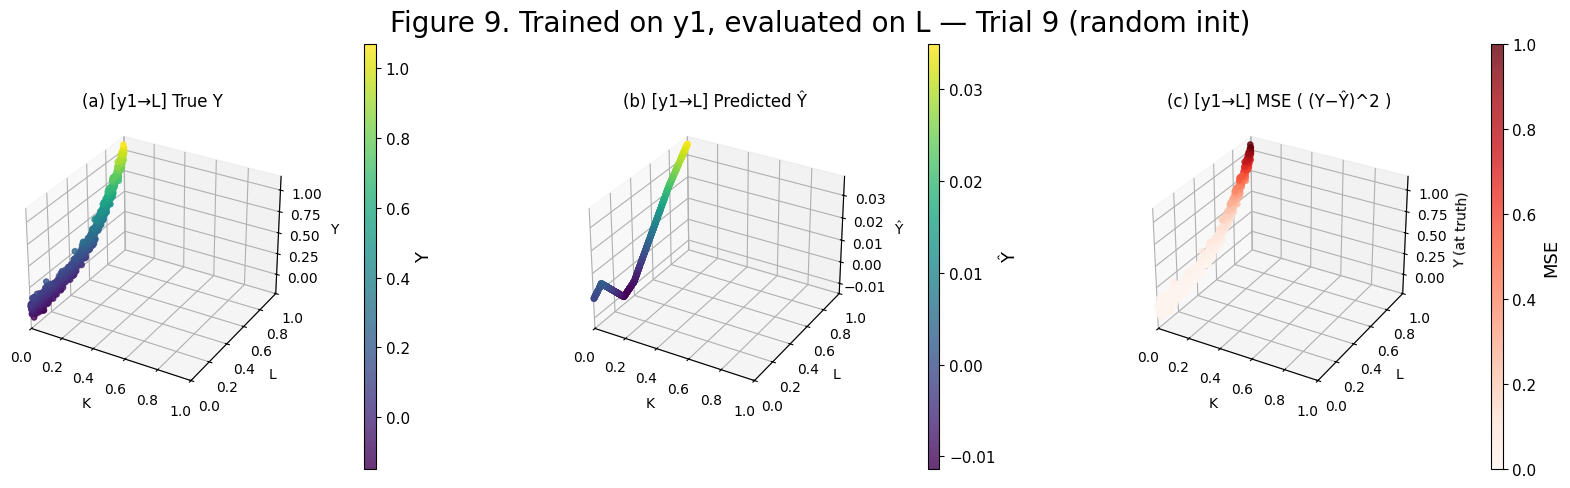

[Trial 10/10] plotting ...


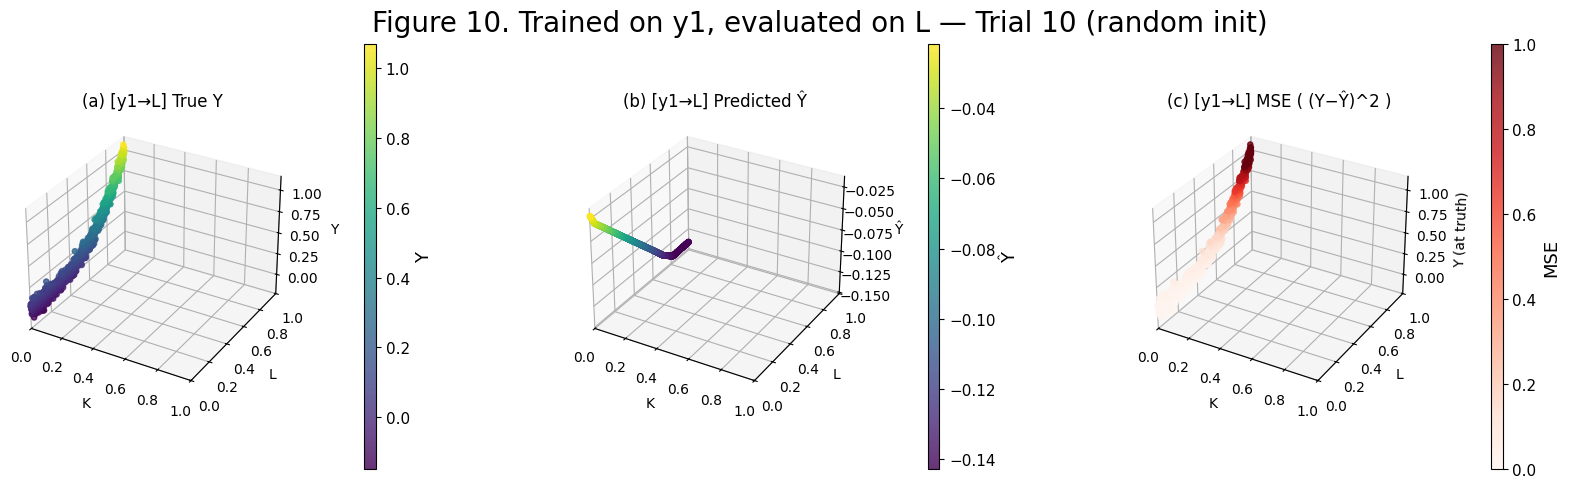

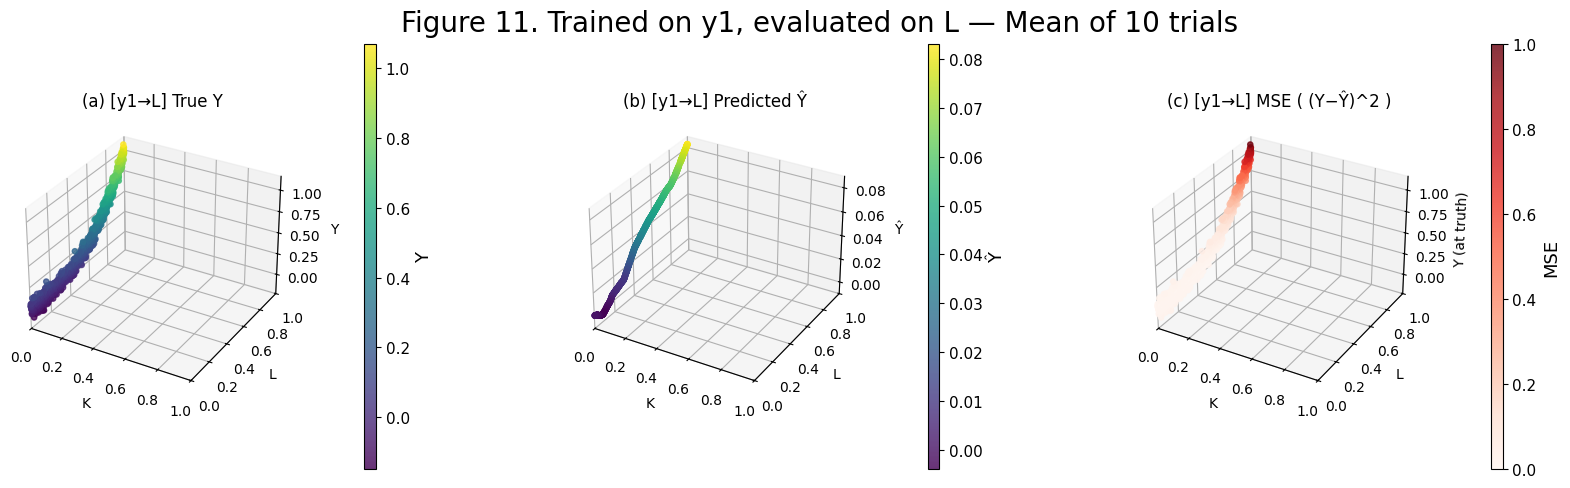

In [9]:
# 10 trials
for t in range(n_trials):
    print(f"[Trial {t+1}/{n_trials}] plotting ...")
    draw_triptych(
        title_prefix="[y1→L]",
        Kv=K0_1d, Lv=L_1d,
        y_true=y3_true_1d, y_pred=y3_preds[t],
        vmin=vmin, vmax=vmax,
        fig_no=t+1,
        caption=f"Trained on y1, evaluated on L — Trial {t+1} (random init)"
    )

# Mean of 10 trials
y3_pred_mean = y3_preds.mean(axis=0)
draw_triptych(
    title_prefix="[y1→L]",
    Kv=K0_1d, Lv=L_1d,
    y_true=y3_true_1d, y_pred=y3_pred_mean,
    vmin=vmin, vmax=vmax,
    fig_no=n_trials+1,
    caption="Trained on y1, evaluated on L — Mean of 10 trials"
)

### Run TL prediction & MSE analysis on y1 -> y2

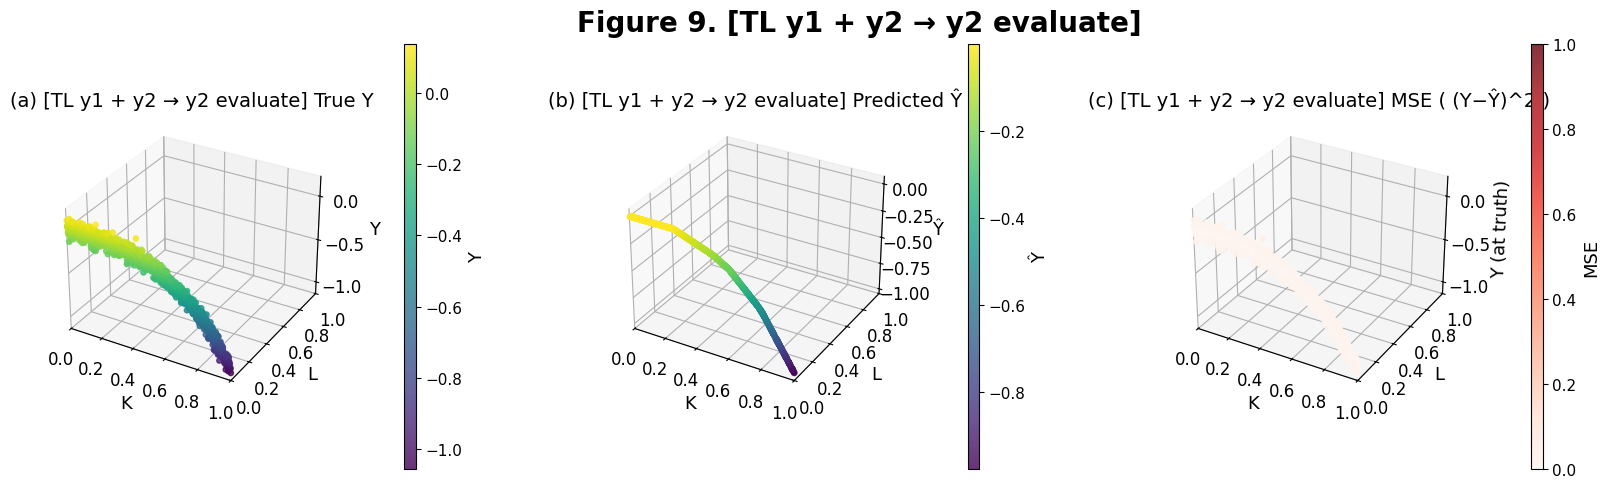

In [37]:
y2_pred_tf = model_tf_y2.predict(X_K, verbose=0)

draw_triptych("[TL y1 + y2 → y2 evaluate]", K, L0,  y2, y2_pred_tf, vmin=0, vmax=1)

### Run TL prediction & MSE analysis on y1 -> y3

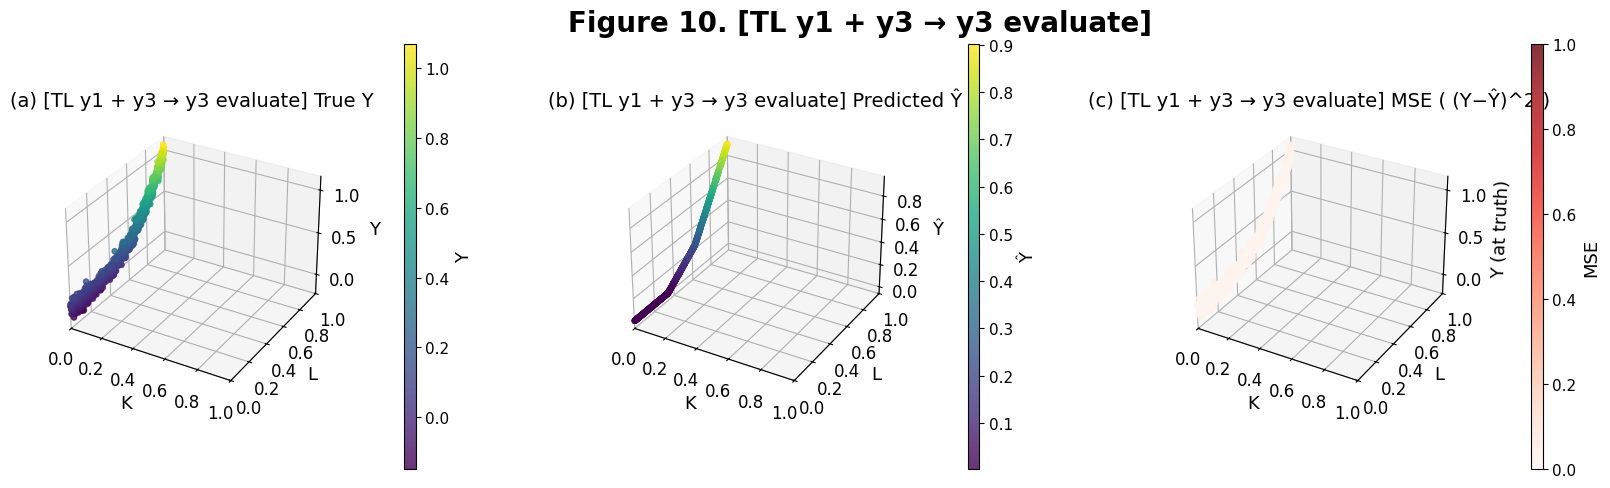

In [38]:
y3_pred_tf = model_tf_y3.predict(X_L, verbose=0)

draw_triptych("[TL y1 + y3 → y3 evaluate]", K0, L, y3, y3_pred_tf, vmin=0, vmax=1)

### Model Structure Visualization

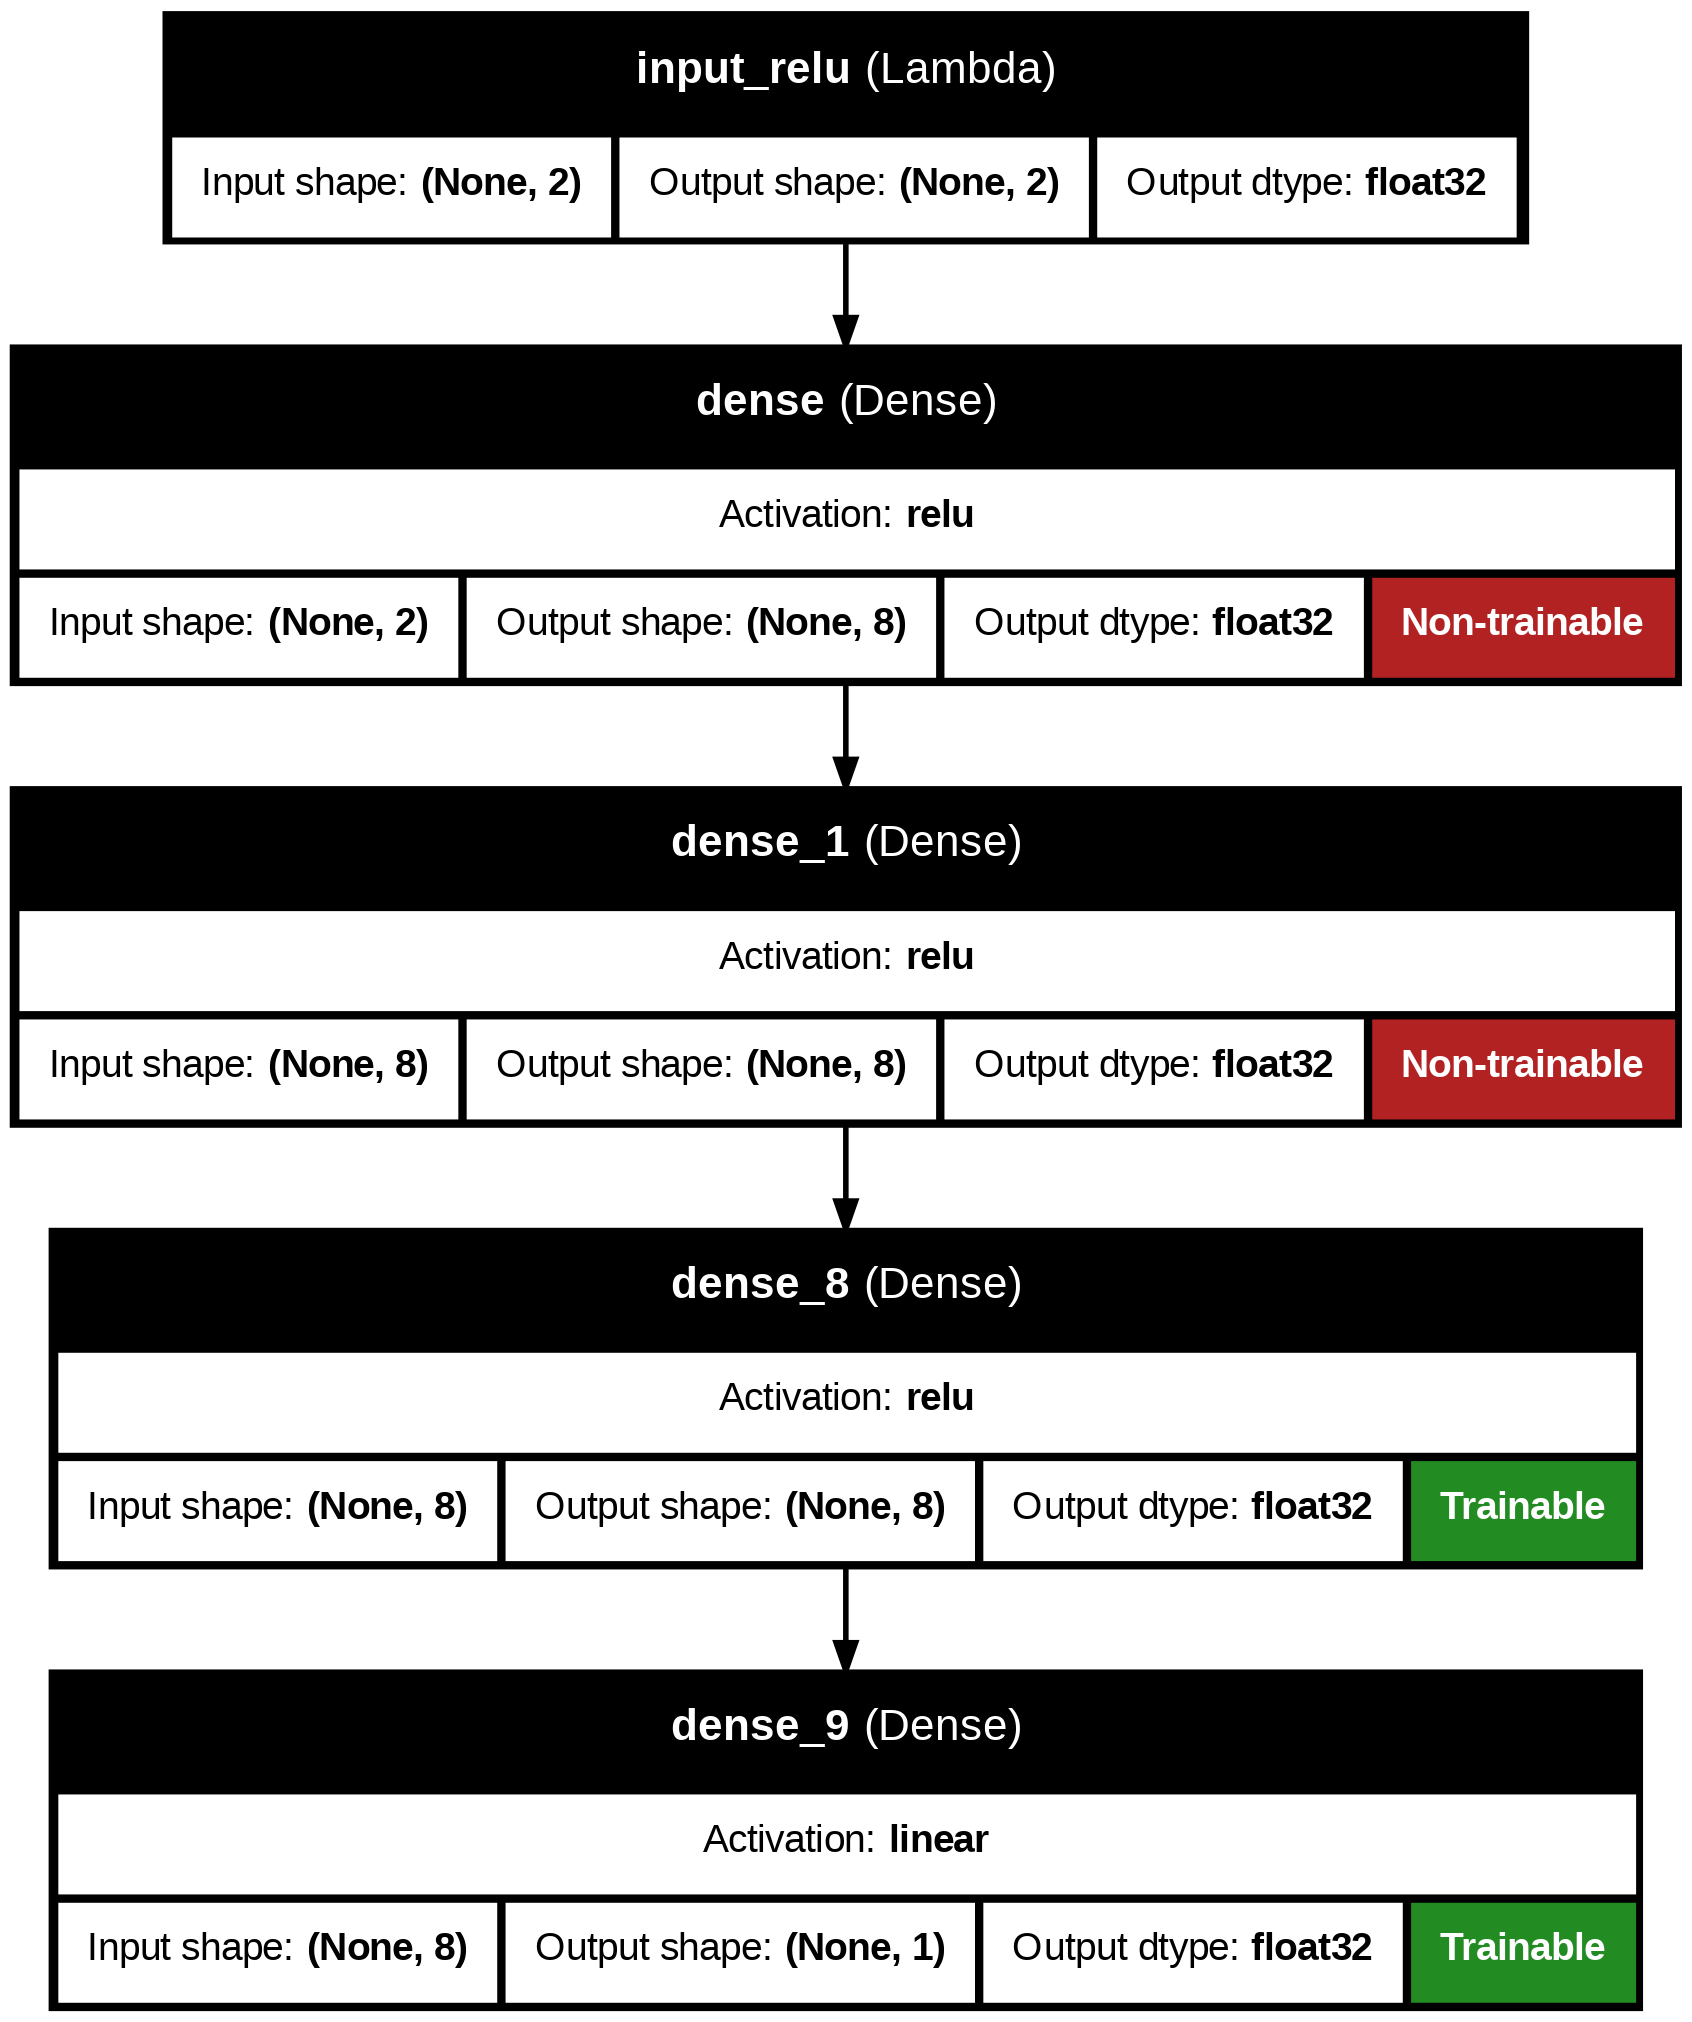

In [13]:
# Original model

tf.keras.utils.plot_model(model, to_file='model_original.png', show_layer_activations=True, show_trainable=True, show_shapes=True, show_dtype=True, show_layer_names=True)

# Transfer learning model 1 (y1 -> y2)

tf.keras.utils.plot_model(model_tf_y2, to_file='model_tf_y2.png', show_layer_activations=True, show_trainable=True, show_shapes=True, show_dtype=True, show_layer_names=True)

# Transfer learning model 1 (y1 -> y3)

tf.keras.utils.plot_model(model_tf_y3, to_file='model_tf_y3.png', show_layer_activations=True, show_trainable=True, show_shapes=True, show_dtype=True, show_layer_names=True)

# Feature Norm

## Helpers

### Feature Path Functions

In [14]:
import matplotlib.style as style

# Set random seed for reproducibility
np.random.seed(42); tf.random.set_seed(42)
rng = np.random.default_rng(42)
style.use('tableau-colorblind10')
plt.rcParams.update({
    'font.size': 14, 'figure.titlesize': 18, 'figure.titleweight': 'bold',
    'figure.subplot.hspace': 0.3, 'figure.subplot.wspace': 0.3, 'axes.titlesize': 14, 'axes.labelsize': 13, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12,
})


# --------------------------
# 1) Robust mask computation
# --------------------------
def get_relu_keep_probs_aligned(model, X_batch):
    """
    Compute per-weight-layer ReLU pass probabilities p = P(z>0).
    Returns:
      masks: list of numpy arrays (or None) for each weight-containing layer (in order encountered)
      layer_indices: list of model.layers indices that correspond to each mask (alignment info)
    Notes:
      - X_batch: tf.Tensor shape (batch, input_dim), representative batch
      - Safe for models that include Activation/Lambda/Dropout/etc.
    """
    X = tf.identity(X_batch)
    masks, layer_indices = [], []

    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            try: # no weights -> forward propagate to update X for subsequent layers
                X = layer(X)
            except Exception:
                # fallback: if layer defines 'activation' wrapper, apply it; else skip
                act = getattr(layer, "activation", None)
                if act is not None:
                    X = act(X)
            continue

        # layer has weights (e.g., Dense). compute pre-activation z = X @ W + b (if present)
        W = ws[0]
        W_tf = tf.convert_to_tensor(W, dtype=tf.float32)
        z = tf.matmul(X, W_tf)
        if len(ws) > 1:
            b_tf = tf.convert_to_tensor(ws[1], dtype=tf.float32)
            z = z + b_tf  # broadcast

        act = getattr(layer, "activation", None)
        masks.append(
            tf.reduce_mean(tf.cast(z > 0.0, tf.float32), axis=0).numpy()
            if (act == tf.keras.activations.relu) else None)
        layer_indices.append(idx)

        try: # propagate X using the actual layer (so next z computed correctly)
            X = layer(X)
        except Exception:
            X = act(z) if act is not None else z


    return masks, layer_indices

def compute_forward_path(
     Ws, Bs, i,
     dense_layer_indices, layer_idxs,
     masks, include_bias=False
):
    input_dim = Ws[0].shape[0]
    if not (0 <= i < input_dim):
        raise ValueError(f"feature index i out of range: i={i}, input_dim={input_dim}")

    # one-hot input e
    e = np.zeros(input_dim, dtype=np.float64)
    e[i] = 1.0

    path, v = [], None
    for k, W in enumerate(Ws):
        if v is None:
            # first weight-layer: contribution e @ W
            v = e @ W  # shape (out_dim,)
        else:
            # find mask position for prev_layer_idx inside dense_layer_indices
            mask_prev = None
            try:  # apply mask corresponding to previous weight-layer (if exists)
                pos = dense_layer_indices.index(layer_idxs[k-1])
                mask_prev = masks[pos]  # might be None
            except ValueError:
                mask_prev = None

            if mask_prev is not None:
                v = v * mask_prev  # elementwise
            v = v @ W # propagate to next layer

        if include_bias and Bs[k] is not None:
            v = v + Bs[k]
        path.append(v.copy())
        print(path[-1].shape, sum(path[-1]**2)**(0.5))
    return path

def layer_stats(path):
  layer_L1 = [np.sum(np.abs(x)) for x in path]
  total = sum(layer_L1) if sum(layer_L1) != 0 else 1.0
  layer_pct = [x / total for x in layer_L1]
  layer_units = [x.shape[0] for x in path]
  return layer_L1, layer_pct, layer_units


# --------------------------
# 2) Feature path computation
# --------------------------
def feature_path(model, i, X_batch, include_bias=False):
    """
    Returns list [v^(1), v^(2), ...] for feature i (one-hot input).
    - X_batch: representative batch (tf.Tensor) for mask estimation
    - include_bias: if True, add layer bias to v^(k) (usually False for 'feature contribution' view)
    The returned path aligns with weight-containing layers only.
    Also returns metadata in dict form.
    """
    masks, dense_layer_indices = get_relu_keep_probs_aligned(model, X_batch)

    # gather weights (+bias optionally) for weight-containing layers, in same encountered order
    Ws, Bs, layer_idxs = [], [], []
    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            continue
        Ws.append(ws[0].astype(np.float64))
        Bs.append((ws[1].astype(np.float64) if (include_bias and len(ws) > 1) else None))
        layer_idxs.append(idx)

    if len(Ws) == 0:
        raise ValueError("Model has no weight-containing layers.")

    path = compute_forward_path(
        Ws, Bs, i, dense_layer_indices,
        layer_idxs, masks, include_bias
    )

    layer_L1, layer_pct, layer_units = layer_stats(path)

    return {
        "path": path,
        "layer_L1": layer_L1,
        "layer_pct": layer_pct,
        "layer_units": layer_units,
        "layer_idxs": layer_idxs,
        "masks": masks,
        "dense_layer_indices": dense_layer_indices
    }


In [15]:
# --------------------------
# 3) Plot helper (no external fm/sp)
# --------------------------
def plot_feature_path(model, num_features, X_batch, vmin=None, vmax=None, cmap='cividis'):
    """
    Plot heatmaps per feature (rows) x weight-layer (cols) and a norm-evolution plot.
    - num_features: how many feature indices [0..num_features-1] to show (rows)
    - X_batch: representative batch for mask computation
    - vmin/vmax: optional fixed color scale; if None scale per whole figure
    """
    # compute all feature paths
    feat_vecs = [feature_path(model, i, X_batch)['path'] for i in range(num_features)]
    cols = len(feat_vecs[0])
    rows = num_features

    # compute global vmin/vmax if not provided
    all_vals = np.concatenate([v.flatten() for row in feat_vecs for v in row])
    if vmin is None:
        vmin = all_vals.min()
    if vmax is None:
        vmax = all_vals.max()
    # symmetric colorbar around 0 if values roughly symmetric
    absmax = max(abs(vmin), abs(vmax))
    vmin, vmax = -absmax, absmax

    fig, axes = plt.subplots(rows, cols, figsize=(2.8*cols, 1.2*rows), squeeze=False)
    fig.suptitle("Feature influence (rows=features, cols=weight-layers)", fontsize=14)

    layer_titles = [f"Weight-layer {k+1}\n(out={feat_vecs[0][k].shape[0]})" for k in range(cols)]

    for i, vecs in enumerate(feat_vecs):
        for k, v in enumerate(vecs):
            ax = axes[i][k]
            ax.imshow(v[np.newaxis, :], aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
            if i == 0:
                ax.set_title(layer_titles[k], fontsize=10)
            if k == 0:
                ax.set_ylabel(f"feat {i+1}", fontsize=9)
            ax.set_yticks([])
            ax.set_xticks([])

    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label("influence value")

    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()

    # norm-evolution plot
    plt.figure(figsize=(6,3))
    for i, vecs in enumerate(feat_vecs):
        norms = [np.linalg.norm(v, 2) for v in vecs]
        plt.plot(range(2, cols+2), norms, marker='o', label=f"feat {i+1}")
    plt.xlabel("weight-layer index")
    plt.ylabel("||influence||_2")
    plt.title("Feature influence norm by layer")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.ylim(0, 2.0)
    plt.show()


### Back Propagation Functions

In [16]:
# -------------------------
# model parameter extractor (Keras -> numpy)
# -------------------------
def get_model_params(model):
    Ws, acts = [], []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
              Ws.append(np.asarray(layer.get_weights()[0]))
              acts.append("relu" if layer.activation == tf.keras.activations.relu else None)
    return Ws, acts

# -------------------------
# utility: ensure rows = samples
# -------------------------
def rows_are_samples(X, in_dim):
    X = np.asarray(X, dtype=float)
    if X.ndim != 2:
        raise ValueError("X must be 2D (samples x features)")
    if X.shape[1] == in_dim:   # already (N, in_dim)
        return X
    if X.shape[0] == in_dim:   # transposed (in_dim, N)
        return X.T
    raise ValueError(f"Neither axis matches in_dim={in_dim}. Got {X.shape}.")

from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
from matplotlib import colors, cm

# -------------------------
# main plotting function
# -------------------------
def plot_delta_flow(model, X, subtitle='', zmax=None, y_scale=1.0):
    """
    Plot ||delta_z||_2 per layer for selected samples.
    - model: tf.keras Model (dense layers)
    - X: array-like, samples x features (or transposed)
    - sample_indices: None (use all) or iterable of indices to plot
    - returns (fig, ax)
    """
    Ws, acts = get_model_params(model)
    if len(Ws) == 0:
        raise ValueError("No dense/kernel layers found in model.")

    in_dim, out_dim = Ws[0].shape[0], Ws[-1].shape[1]
    X_row = rows_are_samples(X, in_dim)
    N = X_row.shape[0]
    if N == 0:
        raise ValueError("No samples selected for plotting (check sample_indices).")

    idxs = list(range(N))
    y_target = np.zeros(out_dim, dtype=float)
    norms_list = []
    # compute per-sample norms
    for c in idxs:
        out = backprop_signals(X_row[c].ravel(), y_target, Ws, acts)
        dzs = out["delta_z"]
        norms_list.append(np.array([np.linalg.norm(dz) for dz in dzs], dtype=float))
    print(c, list(map(lambda x: np.sum(x**2)**(0.5), dzs)), norms_list[-1])
    norms_mat = np.vstack(norms_list)  # (S, L)
    S, L = norms_mat.shape
    layers = np.arange(2, L+2)

    # plotting
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f'Backprop Signal Norms\n{subtitle}', fontsize=14)

    norm = colors.Normalize(vmin=0, vmax=max(S-1, 1))
    cmap = plt.get_cmap('cividis')
    for s in range(S):
        y_vals = np.full(L, s * y_scale)
        z_vals = norms_mat[s]
        ax.plot(layers, y_vals, z_vals, color=cmap(norm(s)), linewidth=1.5, alpha=0.7)
        idx_max = int(np.argmax(z_vals))
        ax.scatter(layers[idx_max], y_vals[idx_max], z_vals[idx_max],
                   color='red', s=30, marker='o', depthshade=True)

    ax.set_xlabel("Layer"); ax.set_ylabel("Sample Index"); ax.set_zlabel("||δ_z||₂")
    if zmax is not None:
        ax.set_zlim(0, zmax)

    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(np.arange(S))
    fig.colorbar(mappable, ax=ax, pad=0.1, label='Sample Index (ordered)')

    plt.tight_layout(); plt.show()
    return fig, ax


### ReLU Location Feature Path Function

In [23]:
from tensorflow.keras.layers import Dense, Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def build_single_relu(where: str):
    """
    Build a network with exactly one ReLU placed at a specified location.
    Architecture: Input → Hidden(8) → Hidden(8) → Hidden(8) → Output(1, linear)
    - 'where' ∈ {'input', 'h1', 'h2', 'h3'}
      * 'input' : ReLU applied on the raw input via a Lambda layer
      * 'h1'    : ReLU as activation of the 1st hidden Dense
      * 'h2'    : ReLU as activation of the 2nd hidden Dense
      * 'h3'    : ReLU as activation of the 3rd hidden Dense
    All other layers use linear activation.
    """
    assert where in {"input", "h1", "h2", "h3"}

    layers = []

    # Input (optionally with ReLU on the input)
    if where == "input":
        layers += [tf.keras.Input(shape=(2,)), Lambda(tf.nn.relu, name="input_relu")]
    else:
        layers += [tf.keras.Input(shape=(2,))]

    # Hidden 1
    act1 = "relu" if where == "h1" else "linear"
    layers += [Dense(8, activation=act1, name="dense1")]

    # Hidden 2
    act2 = "relu" if where == "h2" else "linear"
    layers += [Dense(8, activation=act2, name="dense2")]

    # Hidden 3
    act3 = "relu" if where == "h3" else "linear"
    layers += [Dense(8, activation=act3, name="dense3")]

    # Output (always linear for regression)
    layers += [Dense(1, activation="linear", name="out")]

    model_relu = Sequential(layers)
    model_relu.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    return model_relu


def run_single_relu_experiment(X, y, x_scalar, xlabel, title_prefix,
                               epochs=300, batch_size=64):
    """
    Train/test with identical splits and compare single-ReLU models
    where the only ReLU is placed at: input / h1 / h2 / h3.
    Also plot pairwise differences relative to the Input-ReLU model.
    """
    # --- fixed split for fair comparison ---
    X_tr, X_te, y_tr, y_te, x_tr, x_te = train_test_split(
        X, y, x_scalar, test_size=0.3, random_state=42
    )

    # --- evaluation grid along the active axis ---
    g = np.linspace(0, 1, 400).reshape(-1, 1)
    if xlabel == "K":
        X_grid = np.hstack([g, np.zeros_like(g)])
        y_grid_true = g**3
    else:  # xlabel == "L"
        X_grid = np.hstack([np.zeros_like(g), g])
        y_grid_true = g**3

    # --- build & train 4 models (different single ReLU locations) ---
    models_relu = {
        "Input-ReLU": build_single_relu("input"),
        "H1-ReLU":    build_single_relu("h1"),
        "H2-ReLU":    build_single_relu("h2"),
        "H3-ReLU":    build_single_relu("h3"),
    }
    preds_grid = {}
    test_mse = {}

    for name, m in models_relu.items():
        m.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)
        y_te_pred = m.predict(X_te, verbose=0)
        test_mse[name] = mean_squared_error(y_te, y_te_pred)
        preds_grid[name] = m.predict(X_grid, verbose=0).ravel()

    # pretty print MSEs
    mse_str = ", ".join([f"{k}: {v:.6f}" for k, v in test_mse.items()])
    print(f"[{title_prefix}] Test MSE — {mse_str}")

    # --- (A) prediction curves on grid ---
    plt.figure(figsize=(12, 5))
    plt.plot(g, y_grid_true, lw=2, label="True (noiseless)")
    for name, pred in preds_grid.items():
        plt.plot(g, pred, lw=2, label=name)
    plt.xlim(0, 1)
    plt.xlabel(xlabel); plt.ylabel("y")
    plt.title(f"[{title_prefix}] Single-ReLU location: prediction curves")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # --- (B) difference curves w.r.t. Input-ReLU ---
    base = preds_grid["Input-ReLU"]
    plt.figure(figsize=(12, 4))
    plt.plot(g, preds_grid["H1-ReLU"] - base, label="(H1 - Input)")
    plt.plot(g, preds_grid["H2-ReLU"] - base, label="(H2 - Input)")
    plt.plot(g, preds_grid["H3-ReLU"] - base, label="(H3 - Input)")
    plt.axhline(0, color="black", lw=1)
    plt.xlim(0, 1)
    plt.xlabel(xlabel); plt.ylabel("Δ Prediction")
    plt.title(f"[{title_prefix}] Differences relative to Input-ReLU")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    return models_relu, X_tr  # X_tr can be reused as a representative batch for plot_feature_path


## Run Feature Norm

### Plot Feature Path

(8,) 0.9679513299331937
(8,) 0.3913074566838591
(8,) 0.266305093639669
(1,) 0.07528642740519584
(8,) 1.5354557337050276
(8,) 1.0154764755961878
(8,) 0.8888889452047293
(1,) 0.4353995933652286


/tmp/ipython-input-4192965540.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


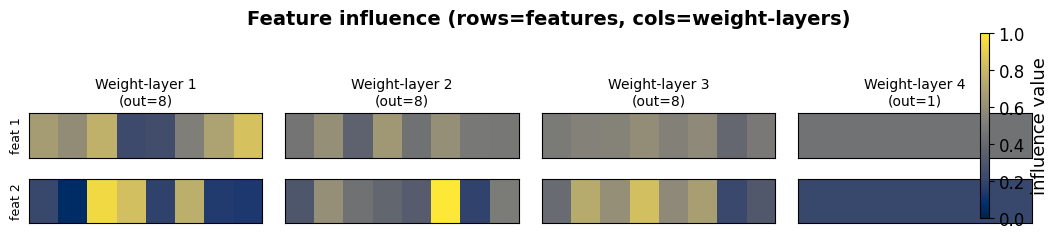

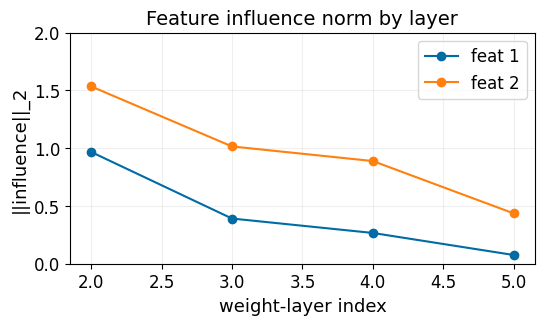

In [18]:
plot_feature_path(model, num_features=2, X_batch=X_L)

(8,) 0.9679513299331937
(8,) 0.3913074566838591
(8,) 0.2494070754355073
(1,) 0.2255089036647361
(8,) 1.5354557337050276
(8,) 1.0154764755961878
(8,) 0.7837948096676646
(1,) 0.6567337276394459


/tmp/ipython-input-4192965540.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


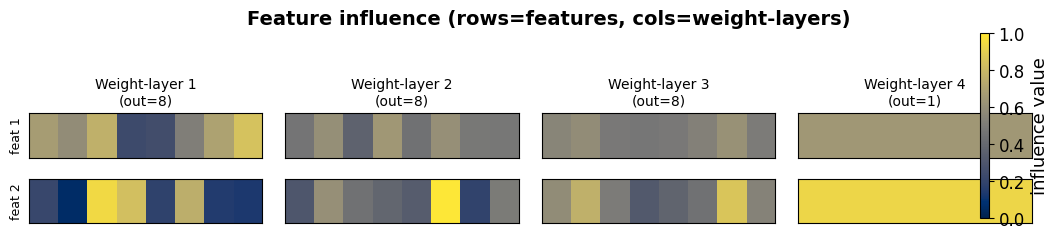

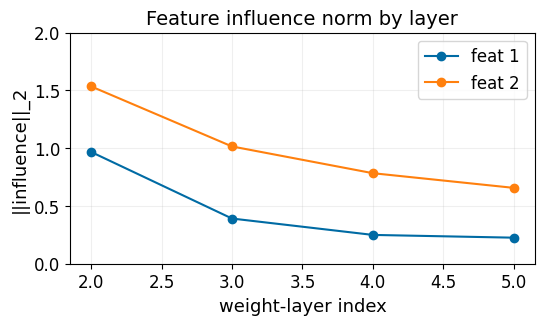

In [19]:
plot_feature_path(model_tf_y3, num_features=2, X_batch=X_L)

### Run Feature Path on ReLU experiment

[K^3 target] Test MSE — Input-ReLU: 0.015055, H1-ReLU: 0.002357, H2-ReLU: 0.002503, H3-ReLU: 0.002433


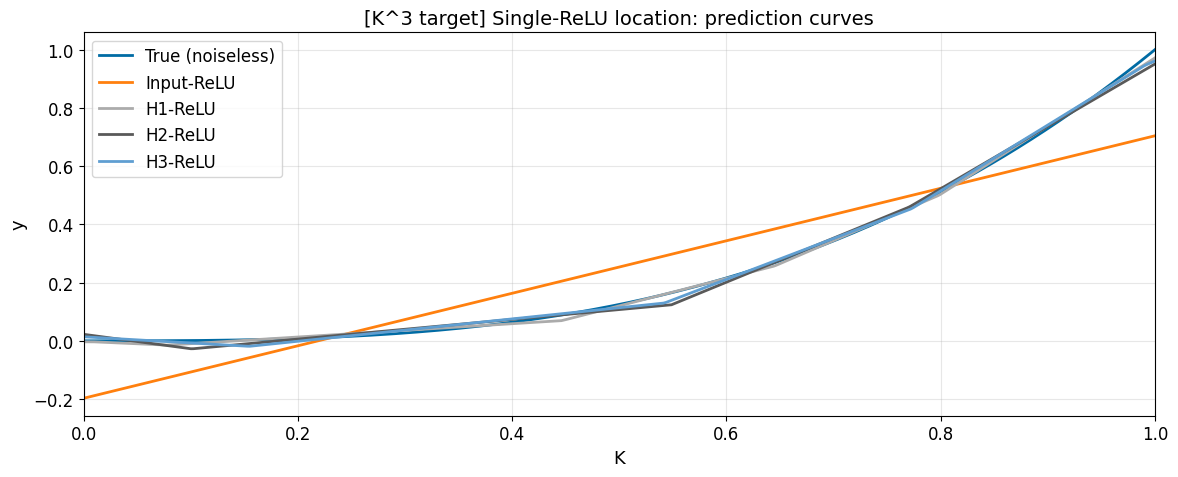

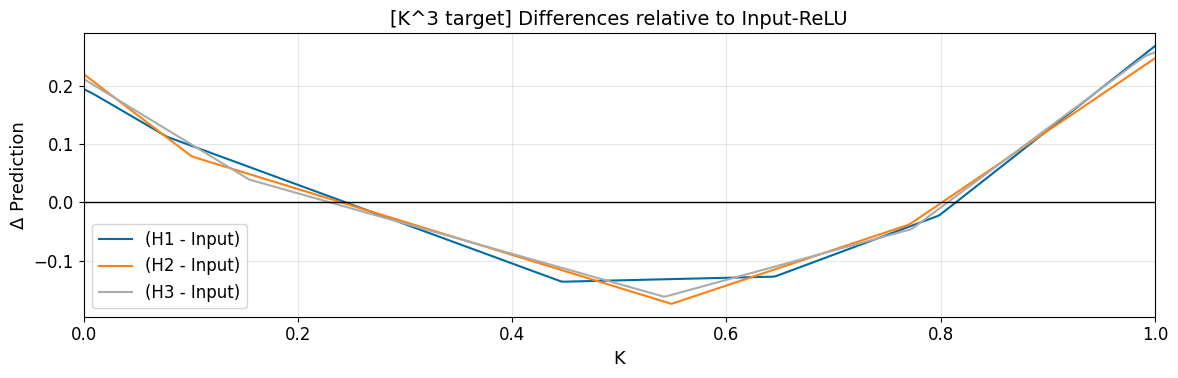

In [24]:
models_loc, X_tr_batch = run_single_relu_experiment(X_K, y1, K, xlabel="K",
                                                    title_prefix="K^3 target")

[Feature Path] Input-ReLU
(8,) 1.0902921468536029
(8,) 0.8122976133192548
(8,) 1.1318590772442867
(1,) 0.901739051123643
(8,) 0.966977904537867
(8,) 1.0177900969352005
(8,) 0.5987489896182574
(1,) 0.593846838445228


/tmp/ipython-input-4192965540.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


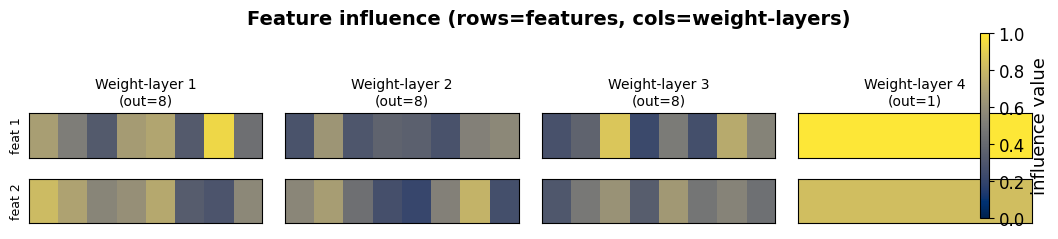

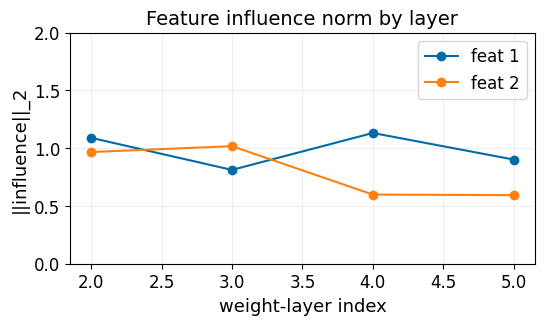

[Feature Path] H1-ReLU
(8,) 1.3769336905182545
(8,) 1.069811422619603
(8,) 1.0907988151000607
(1,) 0.9694818592482495
(8,) 0.9807189153361443
(8,) 0.38616241003733975
(8,) 0.48027230385554637
(1,) 0.4682292033259304


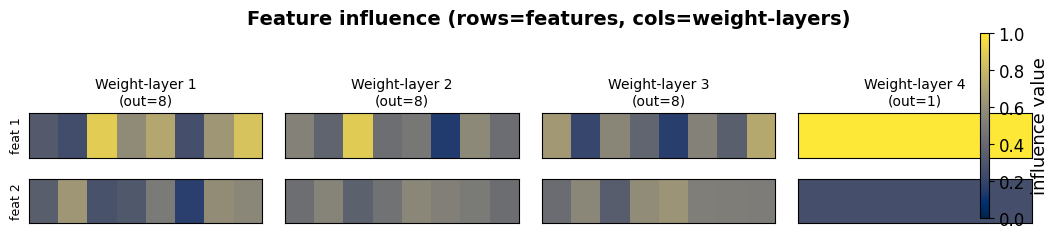

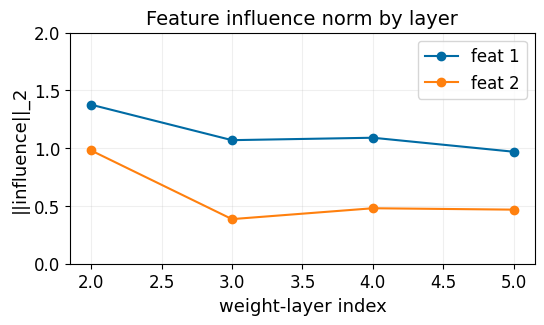

[Feature Path] H2-ReLU
(8,) 1.3546678420312
(8,) 1.2707341592320596
(8,) 0.8418981214271118
(1,) 0.9269249606883927
(8,) 1.4023462648597276
(8,) 1.4017307104587091
(8,) 0.41237739912234955
(1,) 0.4329469202189622


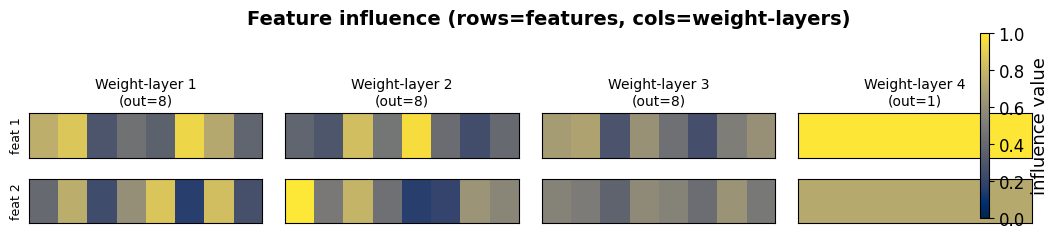

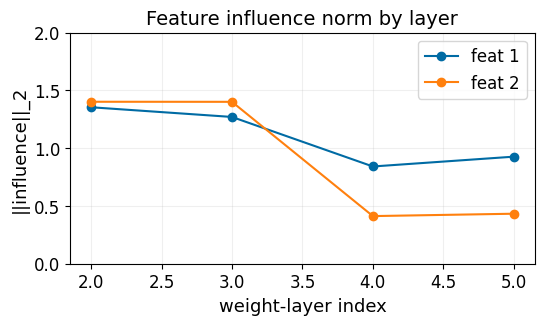

[Feature Path] H3-ReLU
(8,) 1.404994286570743
(8,) 2.119075142024914
(8,) 2.5662831700462077
(1,) 0.9408341735218237
(8,) 1.4348627769226594
(8,) 1.6715441404331028
(8,) 1.6513868712048023
(1,) 0.4364202837718223


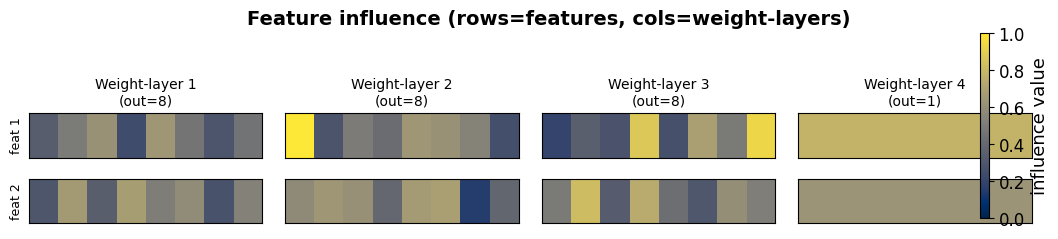

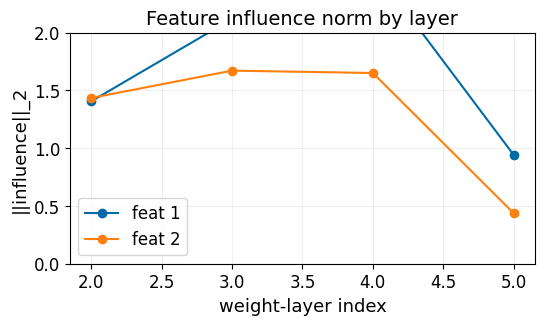

In [25]:
# num_features=2 → feat1=K, feat2=L
for name, m in models_loc.items():
    print(f"[Feature Path] {name}")
    plot_feature_path(m, num_features=2, X_batch=tf.convert_to_tensor(X_tr_batch, dtype=tf.float32))

### Back Propagation Visualize

In [26]:
models_before_after = {'Before Transfer Learning': model, 'After Transfer Learning': model_tf_y3}
for im, vm in models_before_after.items():
  for i, d in enumerate([X_K, X_L]):
      plot_delta_flow(vm, d, subtitle=f'[{im}]\n{["K","L"][i]}-intensive dataset\n')

NameError: name 'backprop_signals' is not defined